# Practical 4: Ocean Colour and Bathymetry Visualization
## Emma de Bruyn, DBREMM005

This notebook demonstrates the visualisation and analysis of chlorophyll concentration and bathymetry data in a selected coastal region using remote sensing data from the ESA-CCI Ocean Colour Climatology and GMRT bathymetry data.

## Introduction

I have chosen a coastal region in the Eastern Cape, specifically around **East London**, for this analysis. Growing up in East London, I developed a deep connection to the ocean, which has always been a significant part of my life. The rich marine environment of the Eastern Cape is not only a place I cherish but also one that plays a crucial role in the local ecosystem. This region is known for its diverse marine life, including areas of high productivity, which makes it an interesting location to explore chlorophyll concentrations and bathymetric features. Given my personal connection to this region and its ecological significance, I thought it would be both meaningful and insightful to analyze the ocean colour data and bathymetry of this area.

###  Importing Required Libraries

In [1]:
pip install xarray netCDF4 matplotlib cartopy cmocean

Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cmocean.cm as cmo

### Loading the Data

Before proceeding with the visualizations, I need to load the bathymetry and chlorophyll concentration data.

### Bathymetry Data:

In [5]:
bathymetry_file = "c:/Users/emmak/OneDrive - University of Pretoria/Desktop/UCT WORK/SCDM/P4/ec_bathymetry.grd"
ds_bathy = xr.open_dataset(bathymetry_file)
print(ds_bathy)
print(ds_bathy.attrs)

<xarray.Dataset> Size: 24MB
Dimensions:   (lon: 1822, lat: 1630)
Coordinates:
  * lon       (lon) float64 15kB 26.5 26.5 26.5 26.5 ... 30.49 30.5 30.5 30.5
  * lat       (lat) float64 13kB -34.5 -34.5 -34.5 -34.5 ... -31.5 -31.5 -31.5
Data variables:
    altitude  (lat, lon) float64 24MB ...
Attributes:
    title:        GMRT Grid
    history:      Projection: Cylindrical Equidistant\nExtracted from the Glo...
    Conventions:  COARDS,CF-1.6
    GMT_version:  4.5.7
{'title': 'GMRT Grid', 'history': 'Projection: Cylindrical Equidistant\nExtracted from the Global Multi-Resolution Topgraphy (GMRT) Synthesis v2.7\nhttp://gmrt.marine-geo.org\nCreated with GMRT GridServer\nhttp://www.marine-geo.org/tools/gridserverinfo.php', 'Conventions': 'COARDS,CF-1.6', 'GMT_version': '4.5.7'}


In [7]:
long = ds_bathy['lon']
lat = ds_bathy['lat']
depth = ds_bathy['altitude']

### Chlorophyll Data:

In [9]:
from netCDF4 import Dataset 
# Load the chlorophyll concentration data (replace with actual file path)
chlorophyll_file = "c:/Users/emmak/OneDrive - University of Pretoria/Desktop/UCT WORK/SCDM/P4/chloro.nc"
chlorophyll_data = Dataset(chlorophyll_file)
print(chlorophyll_data.variables.keys())

# Extract chlorophyll concentration (using the correct variable name 'chlor_a')
chlorophyll = chlorophyll_data.variables['chlor_a'][:]  # Monthly data (time, lat, lon)

dict_keys(['time', 'lon', 'lat', 'crs', 'chlor_a'])


##  Bathymetry Map

I'll begin by visualizing the bathymetry of the selected region using an adequate colourmap.

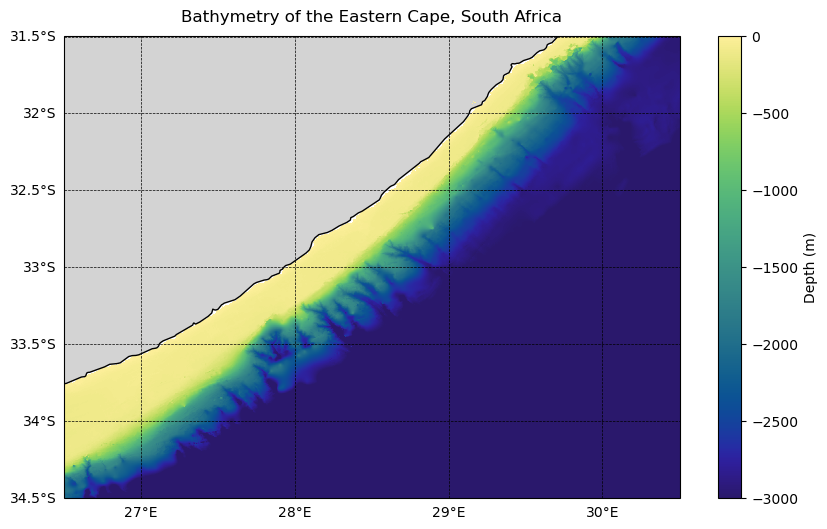

In [10]:
# Set land to grey
land_color = 'lightgrey'

# Mask the land so it's not colored with the ocean colormap
depth_masked = np.where(depth > 0, np.nan, depth)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
p = ax.pcolormesh(long, lat, depth_masked, cmap=cmo.haline, shading='auto', transform=ccrs.PlateCarree(), vmin=-3000, vmax=0)

# Add features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, facecolor=land_color)  # Set land to grey

# Add colorbar
cbar = plt.colorbar(p, ax=ax, orientation='vertical', label='Depth (m)')

import cartopy.mpl.gridliner as cgrid
gl = ax.gridlines(draw_labels=True, color='black', linestyle='--', linewidth=0.5)
gl.right_labels = False  # Hide right labels
gl.top_labels = False  # Hide top labels

# Labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Bathymetry of the Eastern Cape, South Africa")

plt.show()

##### Figure 1: The bathymetry of the selected portion of the Eastern Cape coast, where the depth is represented by colour. The bathymetry data is an essential factor in understanding phytoplankton development, as it can influence nutrient availability.

## Mean Annual Chlorophyll Map

Now, I plot the **mean annual chlorophyll concentration** for the selected region.

In [18]:
# Extract longitude and latitude from the chlorophyll data
lon = chlorophyll_data.variables['lon'][:]
lat = chlorophyll_data.variables['lat'][:]
print(lon.shape)  # Should give you the shape of the longitude array
print(lat.shape)  # Should give you the shape of the latitude array

(8640,)
(4320,)


In [20]:
import gc
gc.collect()

0

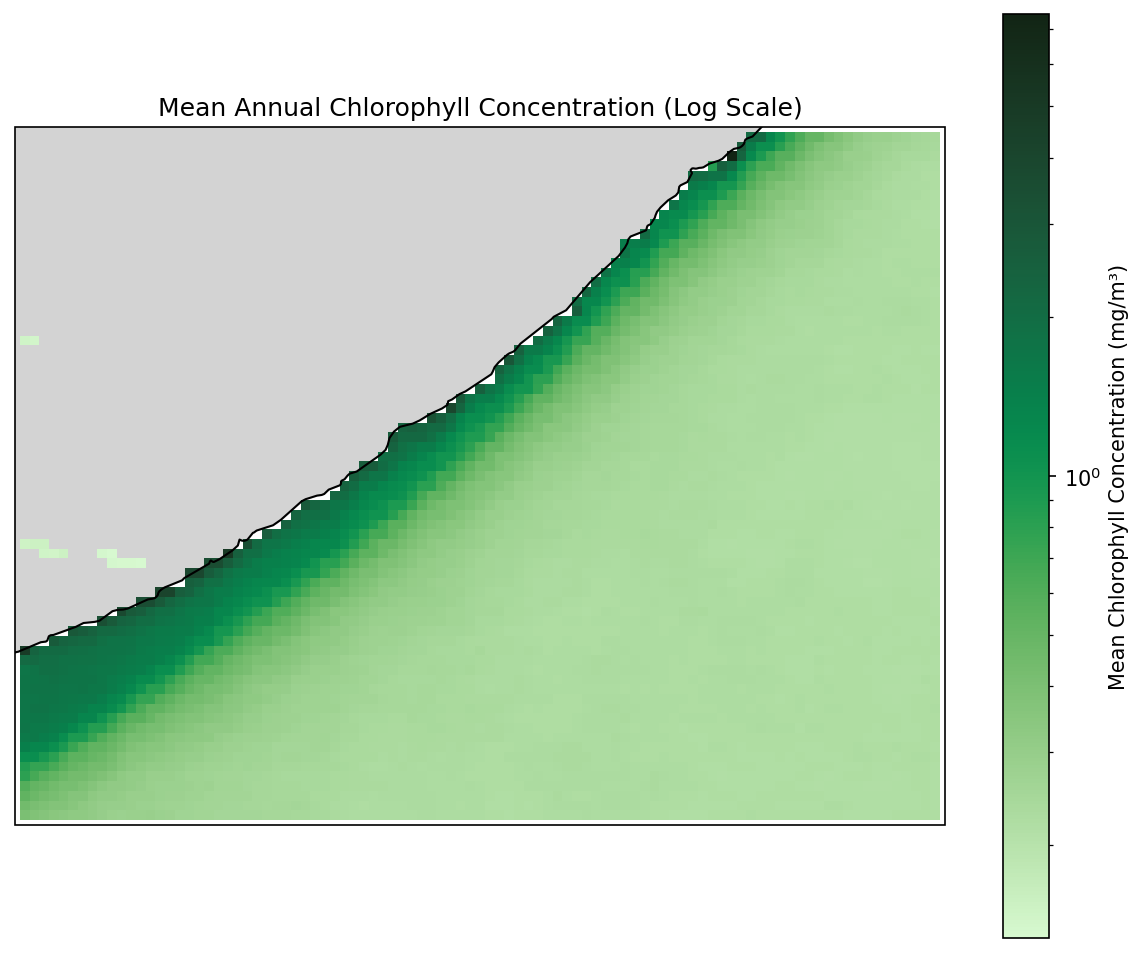

In [26]:
# Install necessary packages if not already installed
!pip install dask cmocean

# Import libraries
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.colors as colors

# Load chlorophyll data using Dask
chlorophyll = da.from_array(chlorophyll_data.variables['chlor_a'][:], chunks=(1, 4320, 8640))

# Define the region of interest (Eastern Cape)
lon_min, lon_max = 26.5, 30.5  # Longitude bounds
lat_min, lat_max = -34.5, -31.5  # Latitude bounds

# Find the indices corresponding to this region
lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]
lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]

# Subset the chlorophyll data to the region of interest
chlorophyll_subset = chlorophyll[:, lat_idx.min():lat_idx.max(), lon_idx.min():lon_idx.max()]

# Compute the mean chlorophyll concentration across all months for the subset region
mean_chlorophyll = chlorophyll_subset.mean(axis=0).compute()

# Avoid zero values in log scaling
mean_chlorophyll[mean_chlorophyll <= 0] = np.nan

# Create a figure for the mean chlorophyll map
fig, ax = plt.subplots(figsize=(10, 8), dpi=150, subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max])  # Adjust extent based on your region

# Plot the mean chlorophyll data with logarithmic scale
c = ax.pcolormesh(lon[lon_idx], lat[lat_idx], mean_chlorophyll, 
                  cmap=cmocean.cm.algae, shading='auto', 
                  norm=colors.LogNorm(vmin=np.nanmin(mean_chlorophyll), 
                                      vmax=np.nanmax(mean_chlorophyll)))

# Add coastlines and features for reference
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Mean Chlorophyll Concentration (mg/m³)')

plt.title('Mean Annual Chlorophyll Concentration (Log Scale)')
plt.show()


### Figure 2: The mean annual chlorophyll concentration in the selected region. Chlorophyll concentration is commonly used as an indicator of phytoplankton biomass, with higher concentrations indicating more productive areas.

##  Monthly Chlorophyll Maps

Next, I create **12 maps**, one for each month, to show the seasonal variation in chlorophyll concentration.

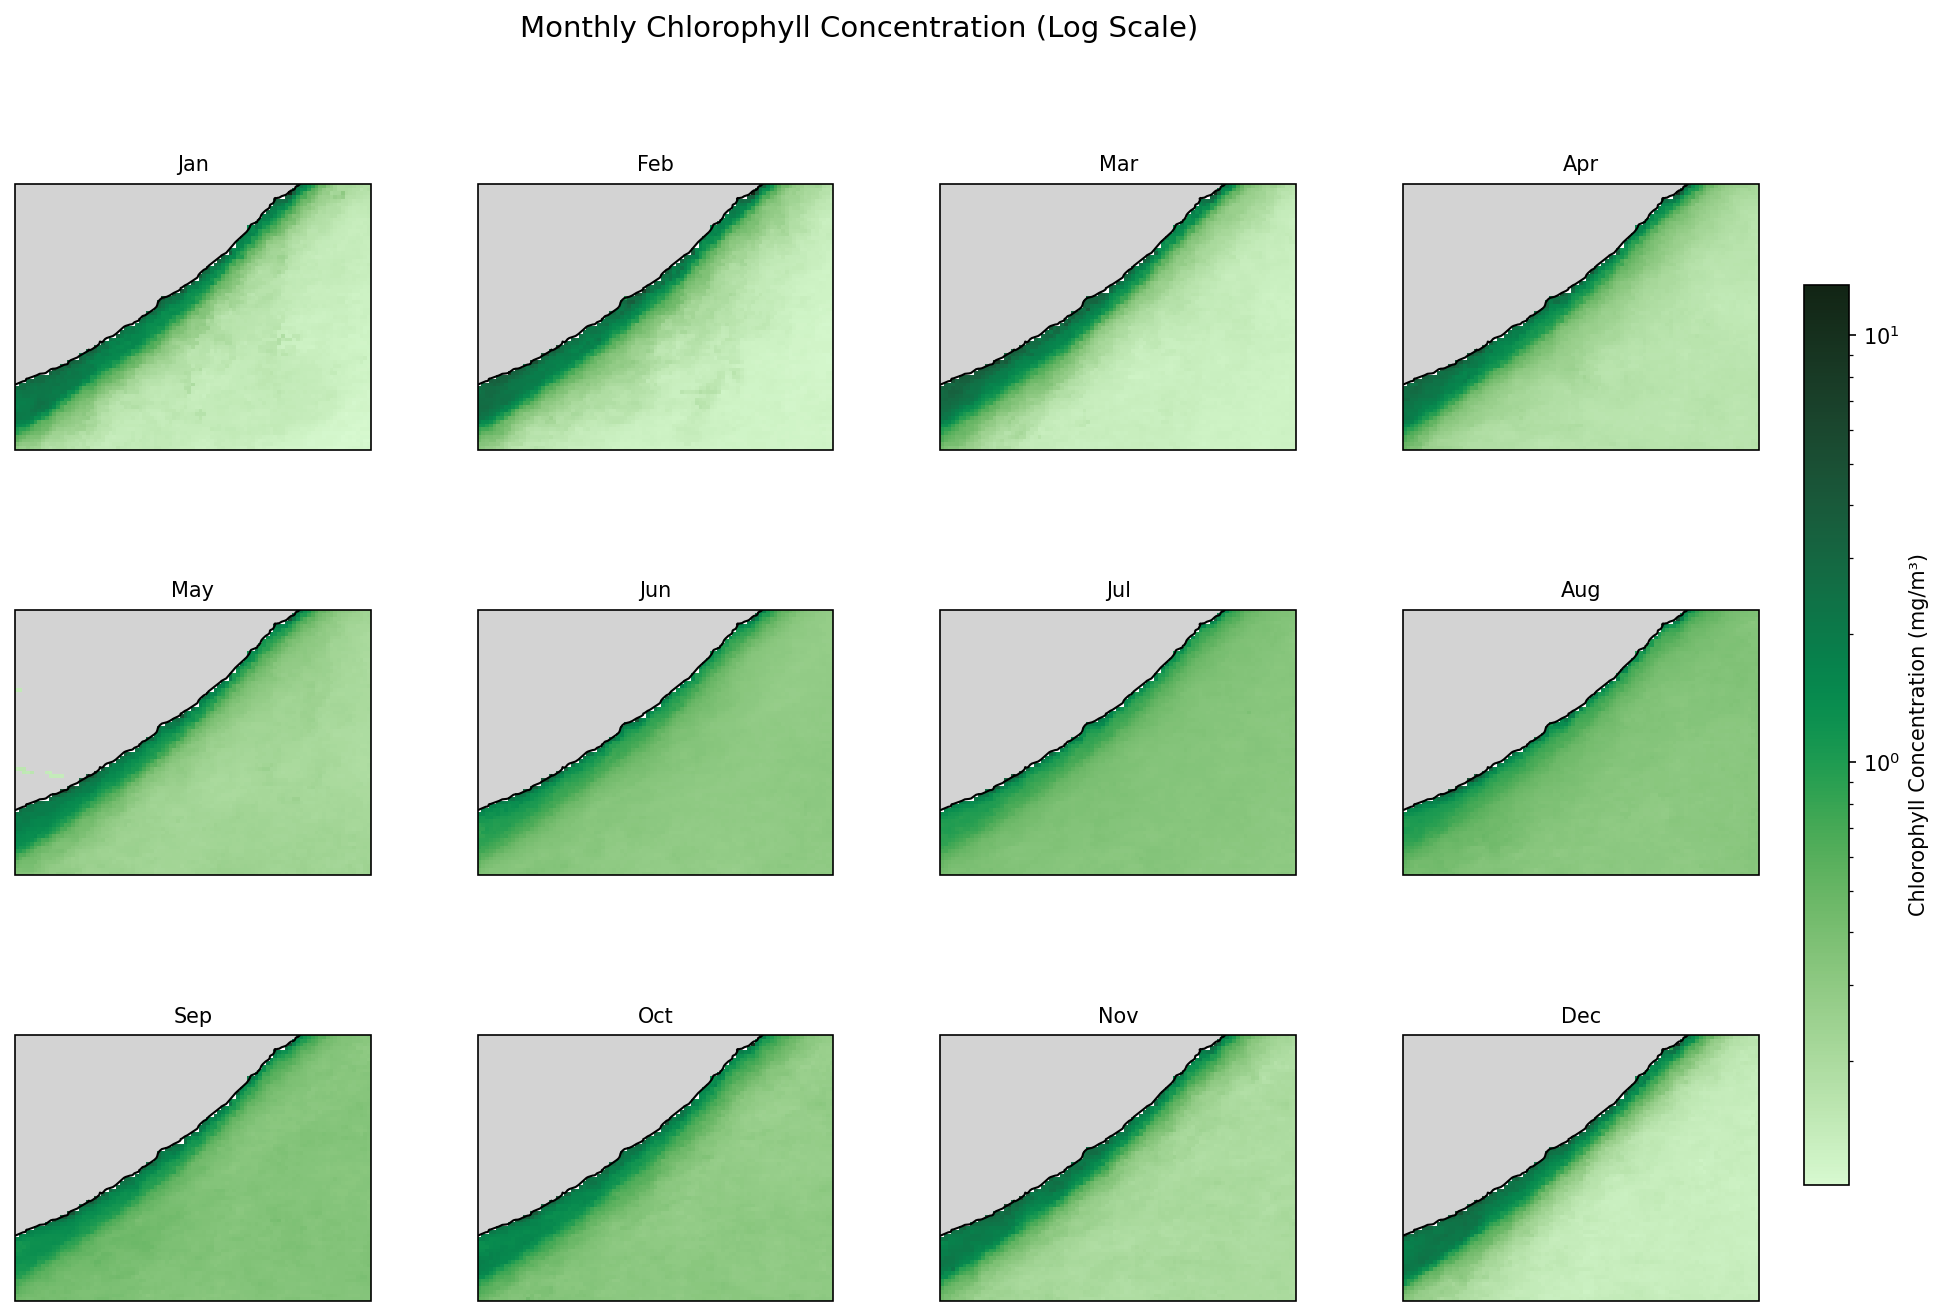

In [38]:
# Create a 3x4 subplot grid for the 12-month maps
fig, axes = plt.subplots(3, 4, figsize=(15, 10), dpi=150, 
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Define a single color scale for all months
vmin = np.nanmin(chlorophyll_subset.compute())
vmax = np.nanmax(chlorophyll_subset.compute())

# Iterate through months (0 to 11)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, ax in enumerate(axes.flat):
    # Extract monthly data and compute
    month_chlorophyll = chlorophyll_subset[i, :, :].compute()
    
    # Replace zero values to avoid log scaling issues
    month_chlorophyll[month_chlorophyll <= 0] = np.nan

    # Plot the chlorophyll data with log scale
    c = ax.pcolormesh(lon[lon_idx], lat[lat_idx], month_chlorophyll, 
                      cmap=cmocean.cm.algae, shading='auto', 
                      norm=colors.LogNorm(vmin=vmin, vmax=vmax))

    # Add coastlines and land features
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')

    # Set title for each subplot
    ax.set_title(months[i], fontsize=10)

# Adjust spacing to avoid overlap
fig.subplots_adjust(wspace=0.3, hspace=0.4)  # Add space between plots

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Move colorbar to the right
fig.colorbar(c, cax=cbar_ax, label='Chlorophyll Concentration (mg/m³)')

plt.suptitle('Monthly Chlorophyll Concentration (Log Scale)', fontsize=14)
plt.show()


### Figure 2: These maps show the seasonal variation in chlorophyll concentration for each month. The color scale is adjusted to highlight changes over the course of the year, indicating how chlorophyll concentration fluctuates with time.

### Time Series Analysis:
Finally, we’ll plot a timeseries to compare the **mean seasonal cycle** for the entire region with a specific grid point's chlorophyll concentration.

Added point at -34.0, 28.0
Added point at -34.5, 27.5
Added point at -33.0, 29.0
Added point at -35.0, 27.0
Created mean from 4 points


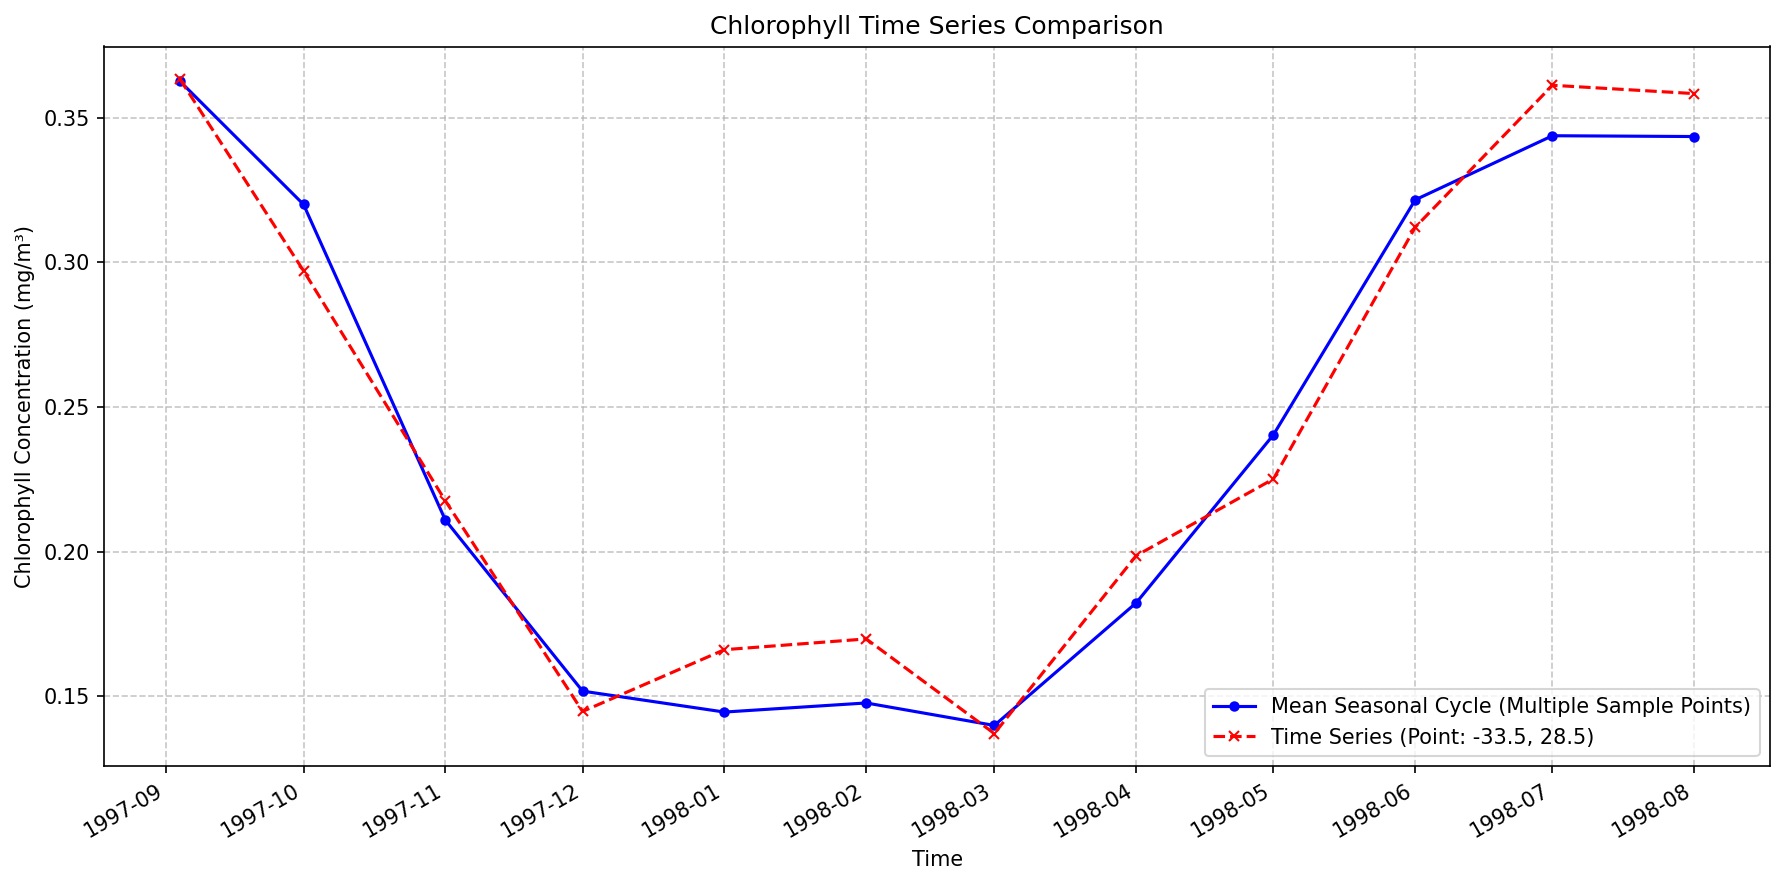

In [70]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the data
ds = xr.open_dataset("c:/Users/emmak/OneDrive - University of Pretoria/Desktop/UCT WORK/SCDM/P4/chloro.nc")

# Sort by time to ensure proper chronological order
ds = ds.sortby('time')

# Define target latitude and longitude for a point in the ocean off East London
lat_target = -33.5  # South of East London
lon_target = 28.5   # East of East London (in the ocean)

# Select chlorophyll data for the point in the ocean
point_chlorophyll = ds['chlor_a'].sel(
    lat=lat_target, lon=lon_target, method='nearest')

# Define a set of sample points in the ocean around Eastern Cape
sample_lats = [-34.0, -34.5, -33.0, -32.5, -35.0]
sample_lons = [28.0, 27.5, 29.0, 28.5, 27.0]

# Collect data for all sample points
sample_data_list = []
for lat, lon in zip(sample_lats, sample_lons):
    try:
        point_data = ds['chlor_a'].sel(lat=lat, lon=lon, method='nearest')
        # Check if point has valid data (not all NaN)
        if not np.isnan(point_data.values).all():
            sample_data_list.append(point_data)
            print(f"Added point at {lat}, {lon}")
    except Exception as e:
        print(f"Error with point {lat}, {lon}: {e}")

# Calculate the mean of these points manually
if sample_data_list:
    # Initialize with first dataset
    mean_data = sample_data_list[0].copy()
    
    # Add the rest and divide by total count
    for i in range(1, len(sample_data_list)):
        mean_data = mean_data + sample_data_list[i]
    
    seasonal_cycle = mean_data / len(sample_data_list)
    print(f"Created mean from {len(sample_data_list)} points")
else:
    # If no valid points, use the target point as a fallback
    seasonal_cycle = point_chlorophyll.copy()
    print("Using target point as fallback for mean")

# Create the time series plot
plt.figure(figsize=(12, 6), dpi=150)

# Plot the mean seasonal cycle
plt.plot(seasonal_cycle['time'], seasonal_cycle, 
         label=f'Mean Seasonal Cycle (Multiple Sample Points)', 
         color='blue', marker='o', markersize=4, linestyle='-', linewidth=1.5)

# Plot the time series for the ocean point
plt.plot(point_chlorophyll['time'], point_chlorophyll, 
         label=f'Time Series (Point: {lat_target}, {lon_target})', 
         color='red', marker='x', markersize=5, linestyle='--', linewidth=1.5)

# Format the x-axis to properly display dates
plt.gcf().autofmt_xdate()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Chlorophyll Concentration (mg/m³)')
plt.title('Chlorophyll Time Series Comparison')
plt.legend()

# Tight layout and show
plt.tight_layout()
plt.show()

### Figure 3: This timeseries compares the mean seasonal cycle of chlorophyll concentration for the entire region with that of a single grid point, which is likely to be located near an area of high chlorophyll concentration.

### Conclusion

In this notebook, we visualized the bathymetry and chlorophyll concentration in a coastal region. We analyzed the seasonal variations in chlorophyll and compared the regional cycle with a grid point’s data. This analysis provides insight into how bathymetric features and seasonal changes influence phytoplankton biomass.


## References
- ESA Ocean Colour Climate Change Initiative (CCI) [ESA Ocean Colour CCI](https://www.esa-oceancolour-cci.org/)
- GMRT (Global Multi-Resolution Topography) Data: [GMRT Data](https://www.gmrt.org/)